In [1]:
# math
import numpy as np
from math import *
from sklearn.linear_model import LinearRegression

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# plot export
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
import os

In [2]:
class RefractTrace():

    def __init__(self, xt_pairs: list):

        # Unpack x-t pairs to separate arrays
        self.x, self.t = xt_pairs.T

        # initialize fitted t array
        self.t_calculated = self.t.copy() 
        self.t_residual = self.t.copy() 

        # check number of points
        self.num_geophones = len(self.x)

    def setup_model(self, breakpoints: list):

        # number of segments for regression
        self.num_segments = len(breakpoints) + 1

        # each segment gets a label: "refracted wave [k]" 
        self.label = [f'Refracted Wave {k}' for k in range(self.num_segments)]
        # except the first segment gets the "direct wave" label
        self.label[0] = 'Direct Wave'

        # initialize a list to assign one of the labels to each data point
        self.label_code = np.zeros(self.num_geophones)
        # Maybe could be refactored as a dict?:
        # self.label_dict = {k: f'Refracted Wave {k}' for k in range(self.num_segments)}

        # Segment breakpoints (inclusive of endpoints)
        self.breakpoints = np.concatenate(([0], breakpoints, [self.num_geophones]))

        # Initialize model (interpretation) variables
        self.velocity = np.zeros(self.num_segments)
        self.thickness = np.zeros(self.num_segments)

    # custom function for code reuse and numerical error handling
    def velocity_func(self, k, n):
        vk = self.velocity[k]
        vn = self.velocity[n]
        if isclose(vn, vk, rel_tol=0.000001):
            raise ValueError('One or more layer boundaries does not reflect a noticeable velocity contrast. Try removing boundaries.')
        elif vn < vk:
            raise ValueError('Critical refraction cannot occur.')
        else:
            return sqrt(vn ** 2 - vk ** 2) / (vn * vk)

    # compute layer velocities and thicknesses
    def model(self):

        # Assume no low-velocity layer to start
        self.hidden = False

        # so one real layer for each linear segment
        self.num_layers = self.num_segments
        self.num_layers_above = 0

        # Handle each segment
        for k in range(self.num_segments):

            # Define kth segment boundaries
            start, stop = self.breakpoints[k], self.breakpoints[k+1]

            # Define kth x- and t-intervals
            x_segment, t_segment = self.x[start:stop], self.t[start:stop]

            # Linear regression matrix: observed column and constant column
            x_matrix = np.column_stack([x_segment, (k > 0) * np.ones(len(x_segment))])

            # Fix t0 = 0 only for first segment
            reg = LinearRegression(fit_intercept = (k > 0)).fit(x_matrix, t_segment)

            # Define kth layer velocity
            self.velocity[k] = 1 / reg.coef_[0]

            # Calculate thickness of layer k - 1
            sum_term = np.sum([2 * self.thickness[j] * self.velocity_func(j, k) for j in range(k - 1)]) # not k-2 since range() excludes upper bound
            self.thickness[k - 1] = (reg.intercept_ - sum_term) / (2 * self.velocity_func(k - 1, k))

            # Calculate fitted t values in kth segment
            self.t_calculated[start:stop] = [reg.coef_[0] * x + reg.intercept_ for x in x_segment]
            self.t_residual[start:stop] = t_segment - self.t_calculated[start:stop]

            # assign label_code k to all points in segment k
            self.label_code[start:stop] = k

    # incorporate low-velocity layer into model
    # replace layer [num_layers_above] (starting from zero) with two new layers: a top layer with thickness: above_layer_thickness and a bottom layer with velocity: low_velocity.
    def model_hidden_layer(self, above_layer_thickness, low_velocity, num_layers_above: int):
        
        # Reset boolean
        self.hidden = True

        # Define position of hidden layer in stack
        self.num_layers_above = num_layers_above

        # one extra layer with no corresponding data segment
        self.num_layers = self.num_segments + 1

        # insert low velocity value into list
        self.velocity = np.insert(self.velocity, self.num_layers_above, low_velocity)

        # New velocity list with one apparent thickness 0
        # This treatment is mainly to match plot colors and indices
        # for actual and apparent sections 
        self.thickness_apparent = np.insert(self.thickness, self.num_layers_above, 0) 

        # calculate thickness of low velocity layer...
        self.hidden_thickness = self.velocity_func(0, self.num_layers_above + 1) * (self.thickness[self.num_layers_above - 1] - above_layer_thickness) / self.velocity_func(self.num_layers_above, self.num_layers_above + 1)

        # ...and add to list of actual velocities
        self.thickness = np.insert(self.thickness, self.num_layers_above, self.hidden_thickness)

        # reset overlying layer thickness as defined
        self.thickness[self.num_layers_above - 1] = above_layer_thickness

    def plot(self, name: str):

        plt.rcParams['svg.fonttype'] = 'none'

        # Set up Labeling
        self.label_obs = [f'{self.label[int(i)]}' for i in self.label_code]
        self.label_calc = [f'$V_{int(i)+1}$: {round(self.velocity[int(i) + all((self.hidden, i > self.num_layers_above - 1))])} m/s' for i in self.label_code]

        # Define figure dimensions
        fig = plt.figure(figsize=(9, 6), dpi=600)

        # subplot syntax: assume an even grid with m rows and n spaces:
        # to place a subplot at position a: (m, n, a)
        # to place a subplot spanning multiple positions with two corners at positions (p,q): (m, n, (p, q))
        if self.hidden:
            ax1 = fig.add_subplot(10, 2, (1, 15))
            ax2 = fig.add_subplot(10, 2, (17, 19))
            ax3 = fig.add_subplot(10, 2, (2, 20))
        else:
            ax1 = fig.add_subplot(10, 3, (1, 23))
            ax2 = fig.add_subplot(10, 3, (25, 29))
            ax3 = fig.add_subplot(10, 3, (3, 30))

        # Trace and linear fit plot
        ax1.set_title("First Return Data")
        ax1.grid(zorder=0, c='black', which='major')
        sns.scatterplot(zorder = 3, x = self.x, y = self.t * 1000, hue = self.label_obs, ax=ax1)
        sns.lineplot(zorder = 2, x = self.x, y = self.t_calculated * 1000, hue = self.label_calc,ax=ax1)
        ax1.set_ylabel('Time (ms)')
        ax1.set_ylim([0, None])
        ax1.set_xlim([0, None])
        ax1.set(xticklabels = [])
        ax1.legend(fancybox=True, framealpha=1)

        # Residual plot
        resid_plot_ylim = 1.2 * max(abs(self.t_residual))
        ax2.set_ylabel('Residuals')
        ax2.set_ylim([-resid_plot_ylim, resid_plot_ylim])
        ax2.set_yticks([0])
        ax2.grid(zorder=0, c='black', axis='y', which='major')
        ax2.vlines(zorder=1, x=self.x, ymin=np.zeros(self.num_geophones), linewidth=0.5, colors='black', ymax=self.t_residual)
        sns.scatterplot(zorder=3, x = self.x, y = self.t_residual, hue = self.label_obs, legend = False, ax = ax2)
        ax2.tick_params(left = True, top = True)
        ax2.set_xlabel('Distance (m)')
        ax2.set_xlim([0, None])

        # set plot thickness of deep layer as a fraction of overlying stack thickness
        bottom_layer_multiplier = 0.1
        label_box_pad = 4

        labels = ["Apparent", "Actual"] if self.hidden else [""]

        if not self.hidden:

            # Single barplot
            self.thickness[-1] = bottom_layer_multiplier * sum(self.thickness[:-1])

            for k in range(self.num_layers):
                has_finite_depth = k + 1 < self.num_layers
                ax3.bar(labels, 
                -self.thickness[k], 
                bottom=-sum(self.thickness[:k]))

                # label center of each layer with V and H
                ax3.text(0, -sum(self.thickness[:k]) - self.thickness[k]/2,
                f"$V_{k+1}$: {round(self.velocity[k])} m/s" + has_finite_depth * "\n" + has_finite_depth * f"$H_{k+1}$: {round(self.thickness[k],1)} m",
                verticalalignment='center',
                horizontalalignment='center',
                bbox={'facecolor': 'white', 'pad': label_box_pad})
        else:
            # Define apparent bottom layer thickness for plotting
            self.thickness_apparent[-1] = bottom_layer_multiplier * sum(self.thickness_apparent[:-1])

            # Define actual bottom layer to match total section thickness
            self.thickness[-1] = sum(self.thickness_apparent) - sum(self.thickness[:-1])

            for k in range(self.num_layers):
                has_finite_depth = k + 1 < self.num_layers
                ax3.bar(labels, 
                [
                    -self.thickness_apparent[k],
                    -self.thickness[k]
                ],
                label=f"$V_{k+1}$: {round(self.velocity[k])} m/s", 
                bottom = [ # "bottom" = closest to zero (top bc inverted)
                    -sum(self.thickness_apparent[:k]),
                    -sum(self.thickness[:k])
                ])

                # Label all apparent layers except hidden (0 thickness)
                if k != self.num_layers_above:

                    # text should be centered at the depth of the stack up to layer k plus half the thickness of layer k
                    x_pos = 0
                    y_pos = -sum(self.thickness_apparent[:k]) - self.thickness_apparent[k]/2

                    # label text
                    text = f"$V_{k+1}$: {round(self.velocity[k])} m/s" + has_finite_depth * "\n" f"$H_{k+1}$: {round(self.thickness_apparent[k],1)} m"

                    # label with velocity (all) and thickness (if not bottom)
                    ax3.text(x_pos, y_pos, text,
                    verticalalignment='center',
                    horizontalalignment='center',
                    bbox={'facecolor': 'white', 'pad': label_box_pad})

                # Label all actual layers

                # text should be centered at the depth of the stack up to layer k plus half the thickness of layer k
                x_pos = 1            
                y_pos = -sum(self.thickness[:k]) - self.thickness[k]/2

                text = f"$V_{k+1}$: {round(self.velocity[k])} m/s" + has_finite_depth * "\n" f"$H_{k+1}$: {round(self.thickness[k],1)} m"

                ax3.text(x_pos, y_pos, text,
                verticalalignment='center',
                horizontalalignment='center',
                bbox={'facecolor': 'white', 'pad': label_box_pad})

        ax3.yaxis.set_label_position("right")
        ax3.tick_params(bottom = False, left = True, right = True, labelright=True)

        # label positive depth
        depth_ticks = ax3.get_yticks()
        ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])
            
        ax3.set_ylabel('Depth (m)')
        ax3.set_title('Subsurface Model')

        # save as svg file
        fig.savefig("plot.svg")

        # convert svg to pdf 
        drawing = svg2rlg("plot.svg")
        renderPDF.drawToFile(drawing, f"{name}.pdf")
        # alternative pdf converter: https://convertio.co

        # clear svg file
        os.remove("plot.svg")

    def print_model(self):
        for k in range(self.num_layers):
            print(f"Layer {k+1}: Thickness = {self.thickness[k]} Velocity = {self.velocity[k]} m")
        print('Note that bottom layer thickness is as shown on the model, this number could be theoretically infinite.')

    def write_file_for_REFRACT(self, filename_str):

        self.shot_offset = self.x[0]
        self.geophone_spacing = self.x[1] - self.x[0]

        # File Preamble
        lines = [
            f"NumberGeophones,{self.num_geophones}",
            f"ShotOffset,{self.shot_offset}",
            f"GeophoneSpacing,{self.geophone_spacing}",
            f"FirstGeophone,0",
        ]

        # Data entries
        for i in range(self.num_geophones):
            lines.append(f"Time,{i},{self.t[i]},{self.t[-(i+1)]}")

        # Write file
        with open(f'{filename_str}.txt', 'w') as f:
            for line in lines:
                f.write(line)
                f.write('\n')

<ipython-input-2-7793b6315cec>:46: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(vn ** 2 - vk ** 2) / (vn * vk)
<ipython-input-2-7793b6315cec>:240: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])


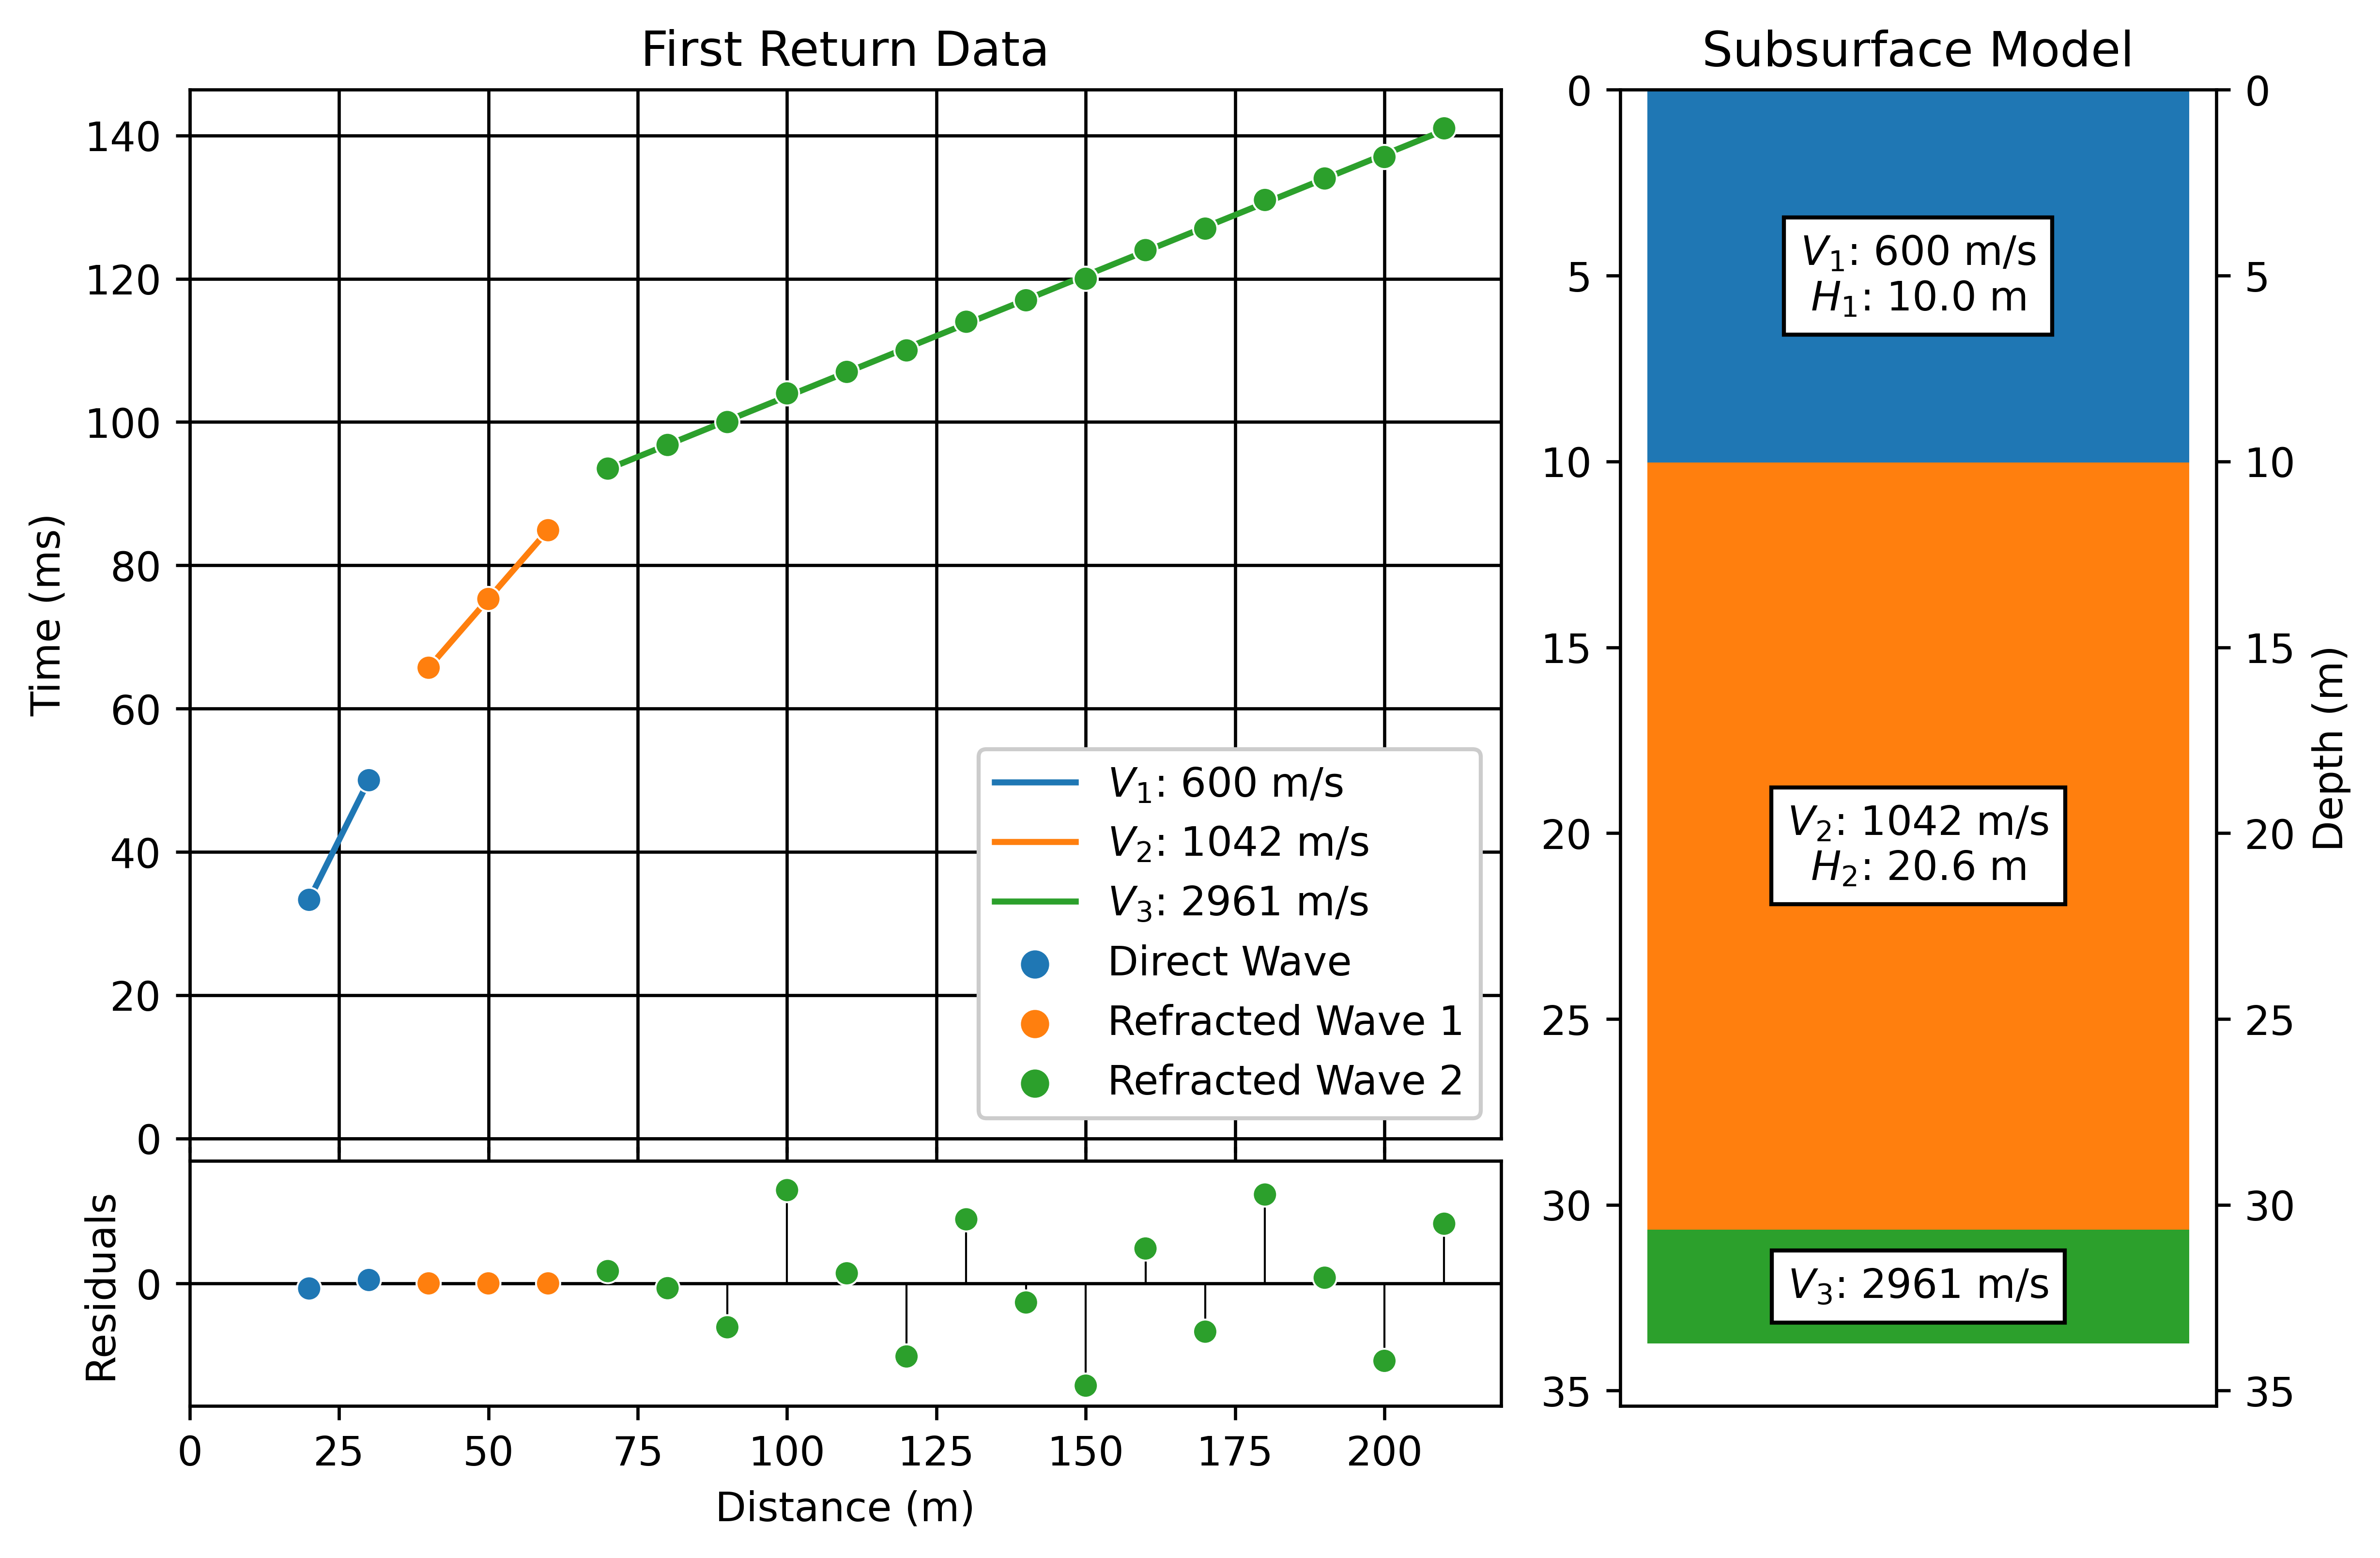

In [3]:
data_TR = np.array([
    [20	,33.3],
    [30, 50],
    [40, 65.7],
    [50, 75.3],
    [60, 84.9],
    [70, 93.5],
    [80, 96.8],
    [90, 100],
    [100, 104],
    [110, 107],
    [120, 110],
    [130, 114],
    [140, 117],
    [150, 120],
    [160, 124],
    [170, 127],
    [180, 131],
    [190, 134],
    [200, 137],
    [210, 141]
    ])

data_TR[:,1] = data_TR[:,1] / 1000

trace_TR = RefractTrace(data_TR)
trace_TR.setup_model(breakpoints=[2, 5])
trace_TR.model()

trace_TR.plot("TR")

<ipython-input-118-9f2144c275d3>:45: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(vn ** 2 - vk ** 2) / (vn * vk)
<ipython-input-118-9f2144c275d3>:148: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([int(1000 * tick) for tick in time_ticks])
<ipython-input-118-9f2144c275d3>:242: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])
<ipython-input-118-9f2144c275d3>:45: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(vn ** 2 - vk ** 2) / (vn * vk)
<ipython-input-118-9f2144c275d3>:148: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([int(1000 * tick) for tick in time_ticks])
<ipython-input-118-9f2144c275d3>:242: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])
<ipy

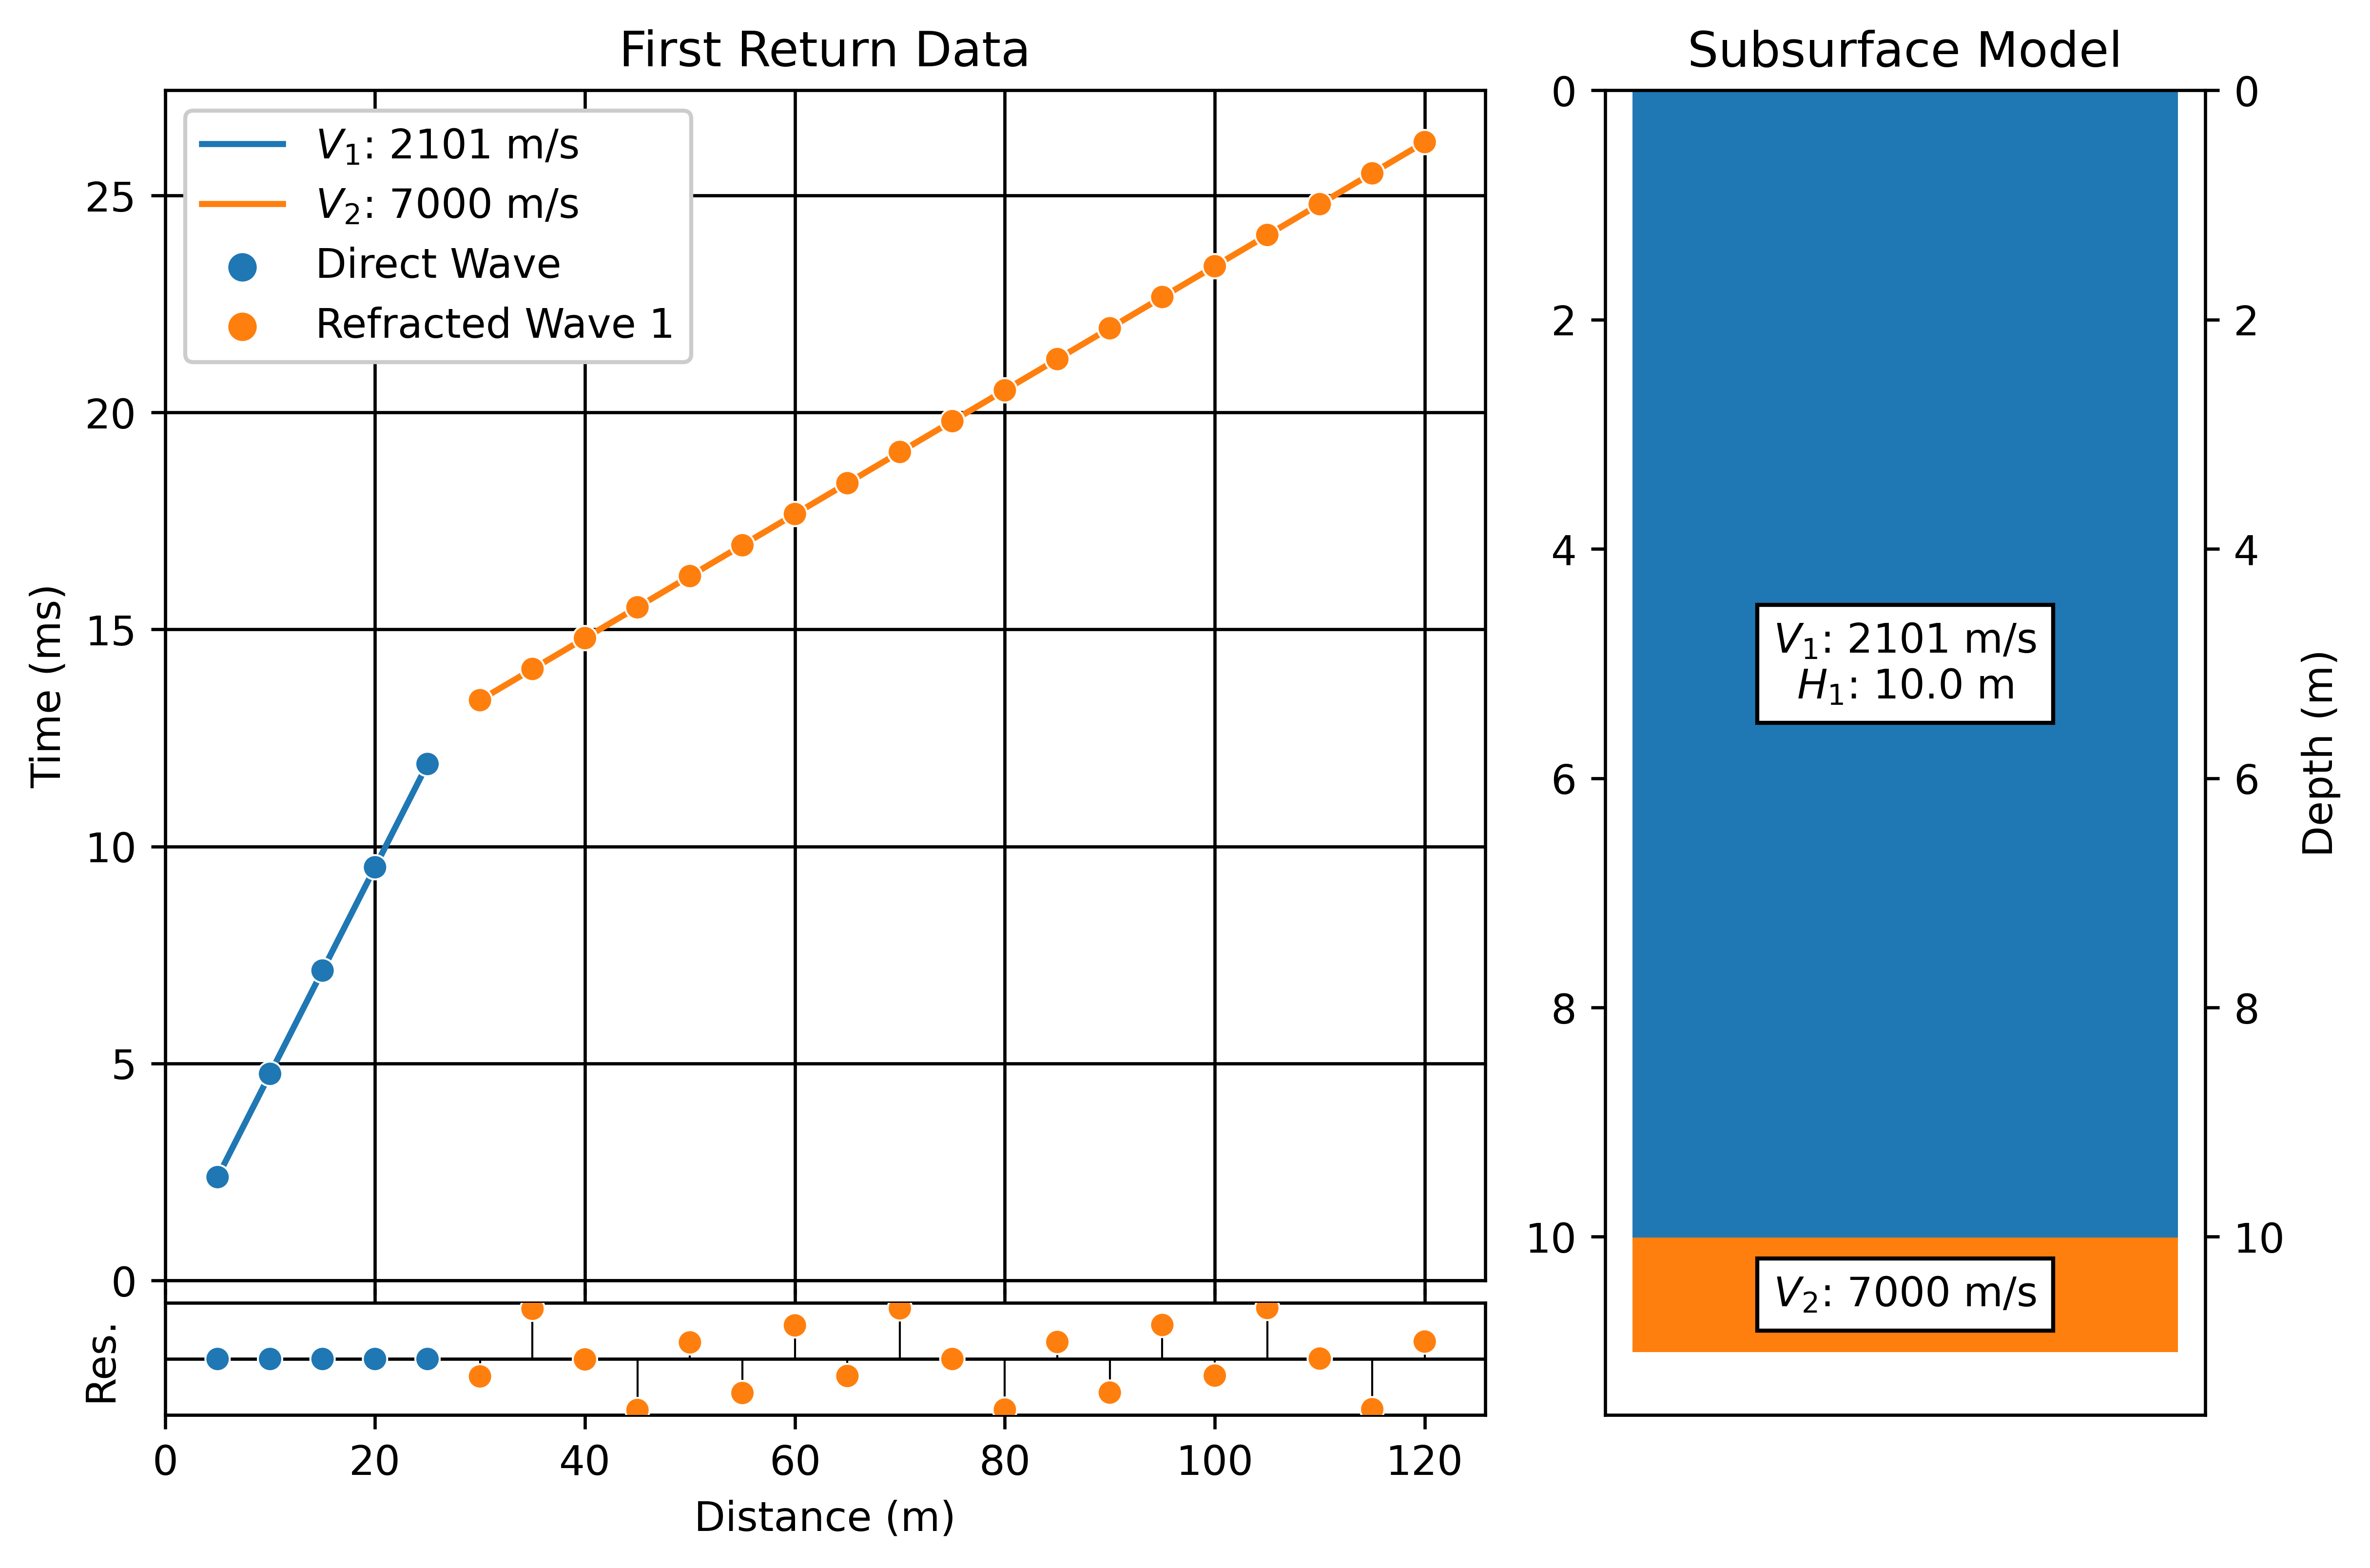

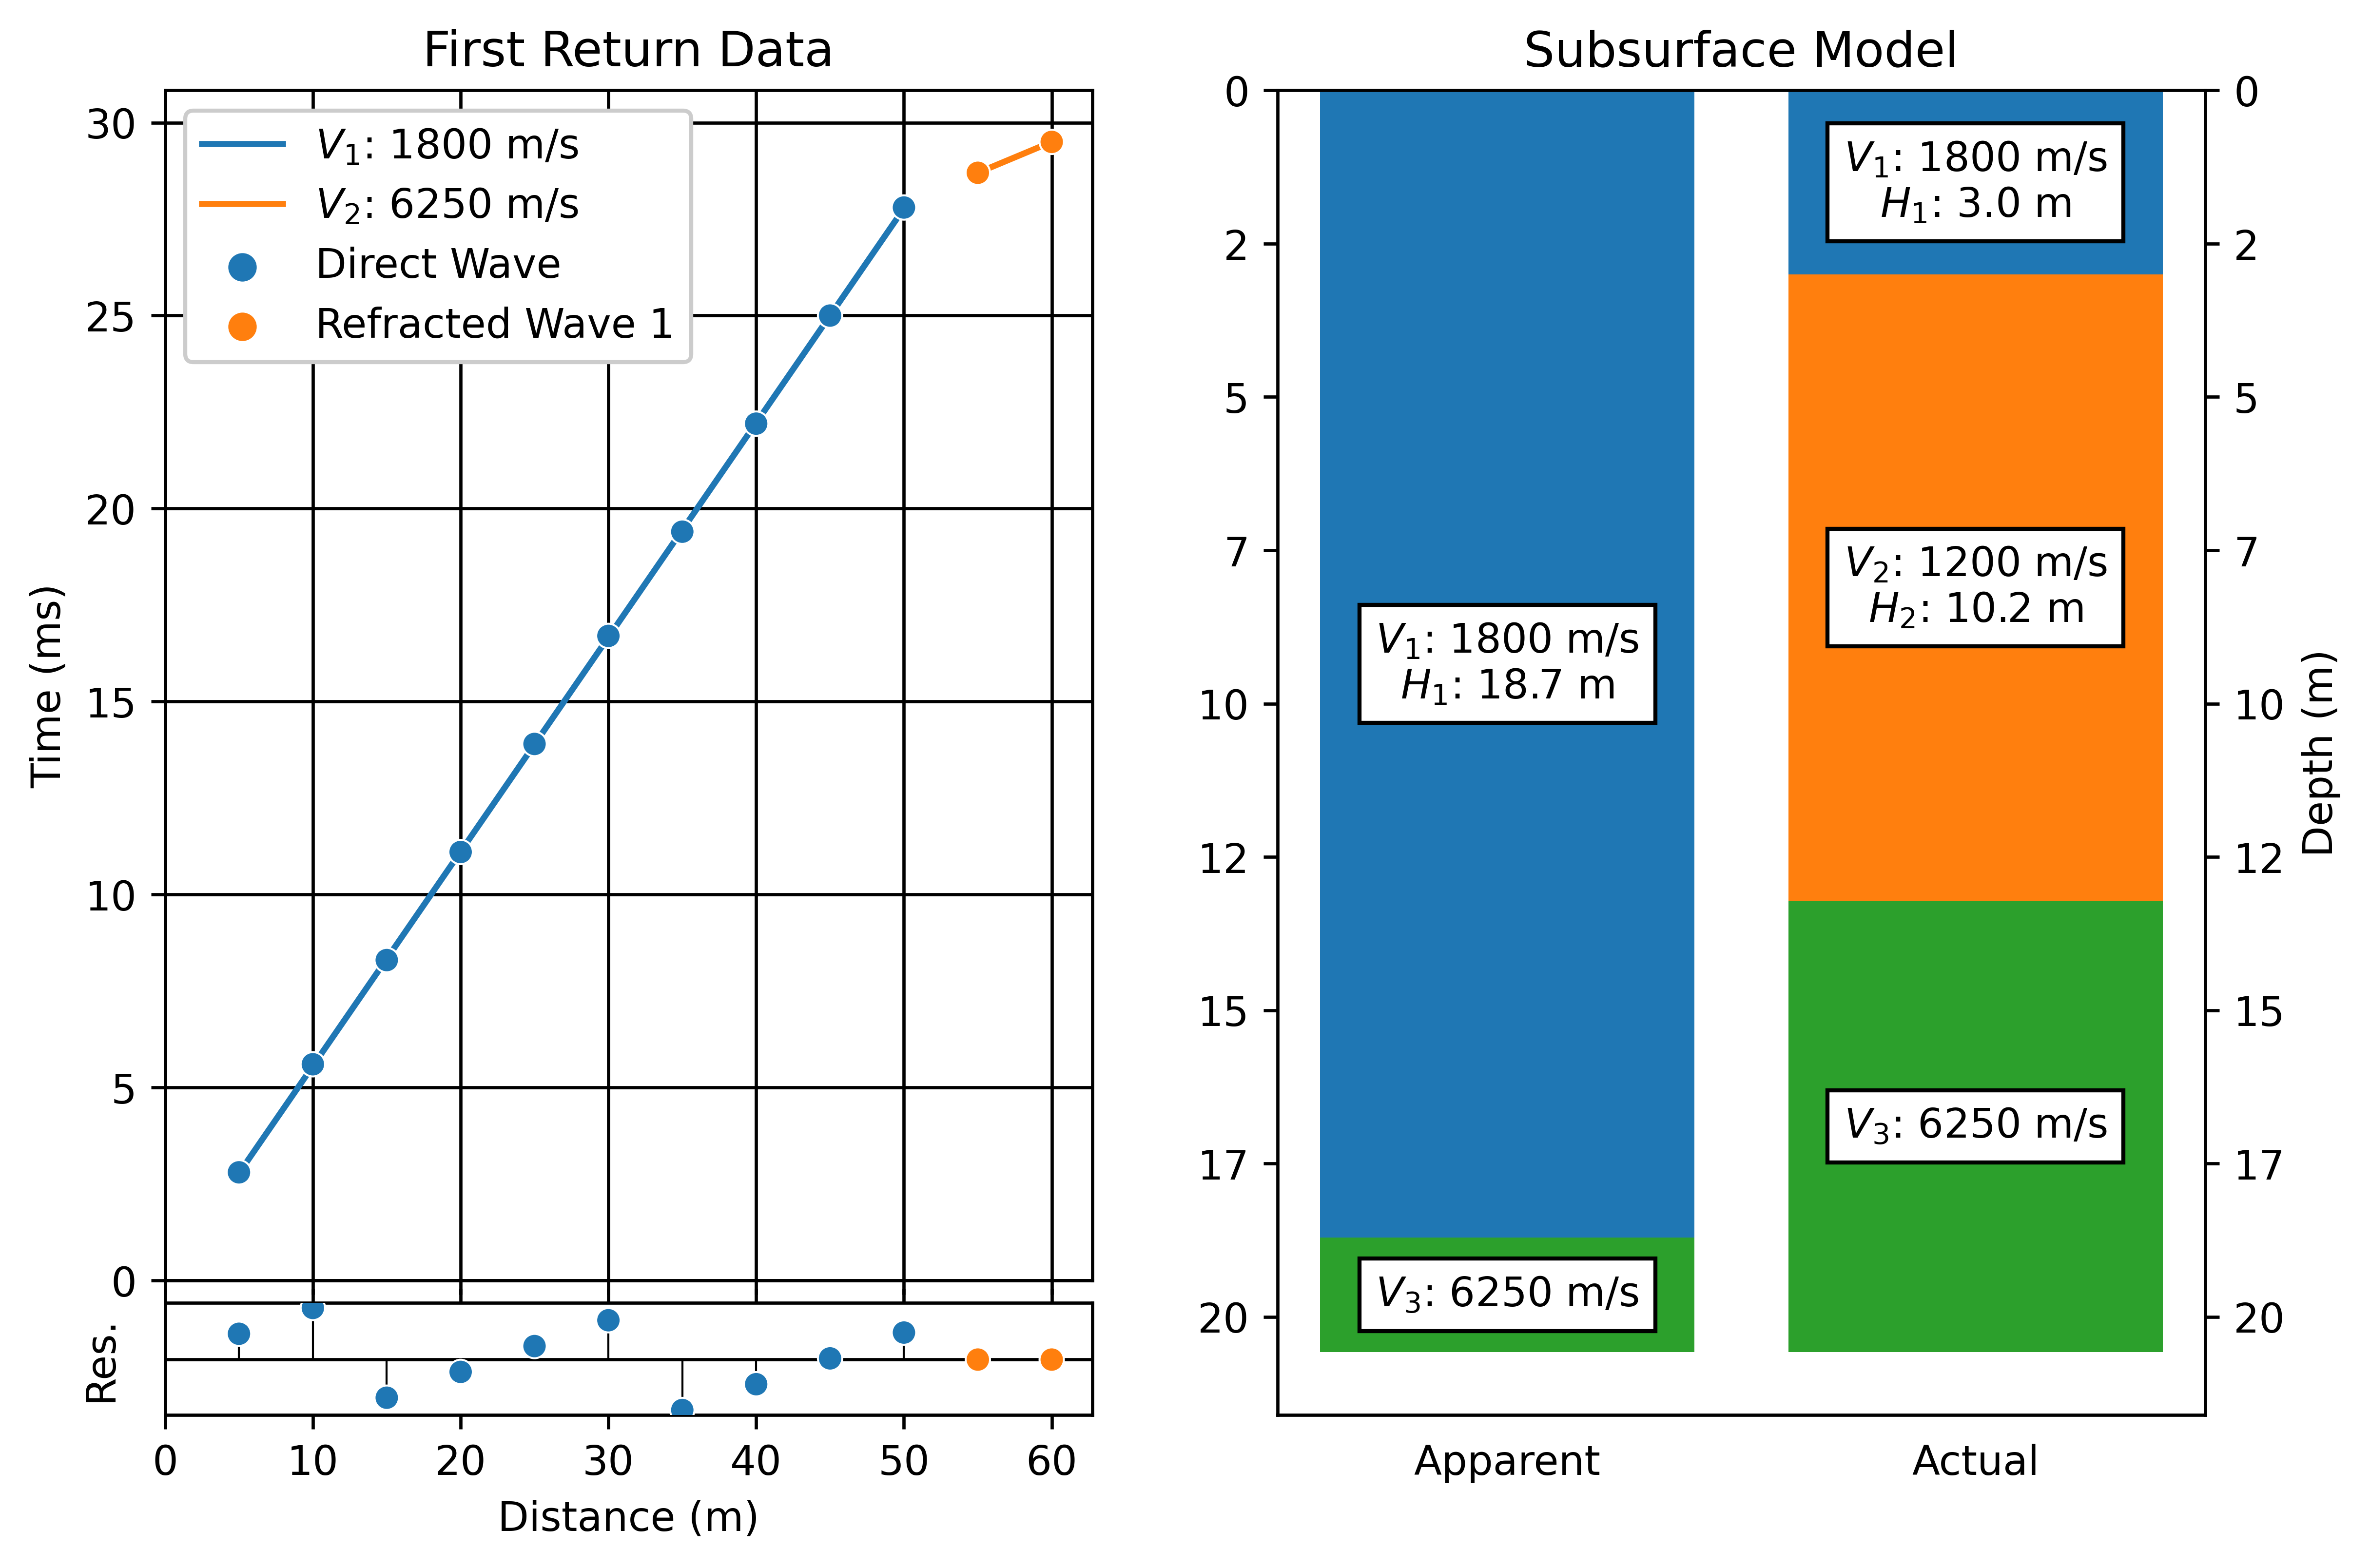

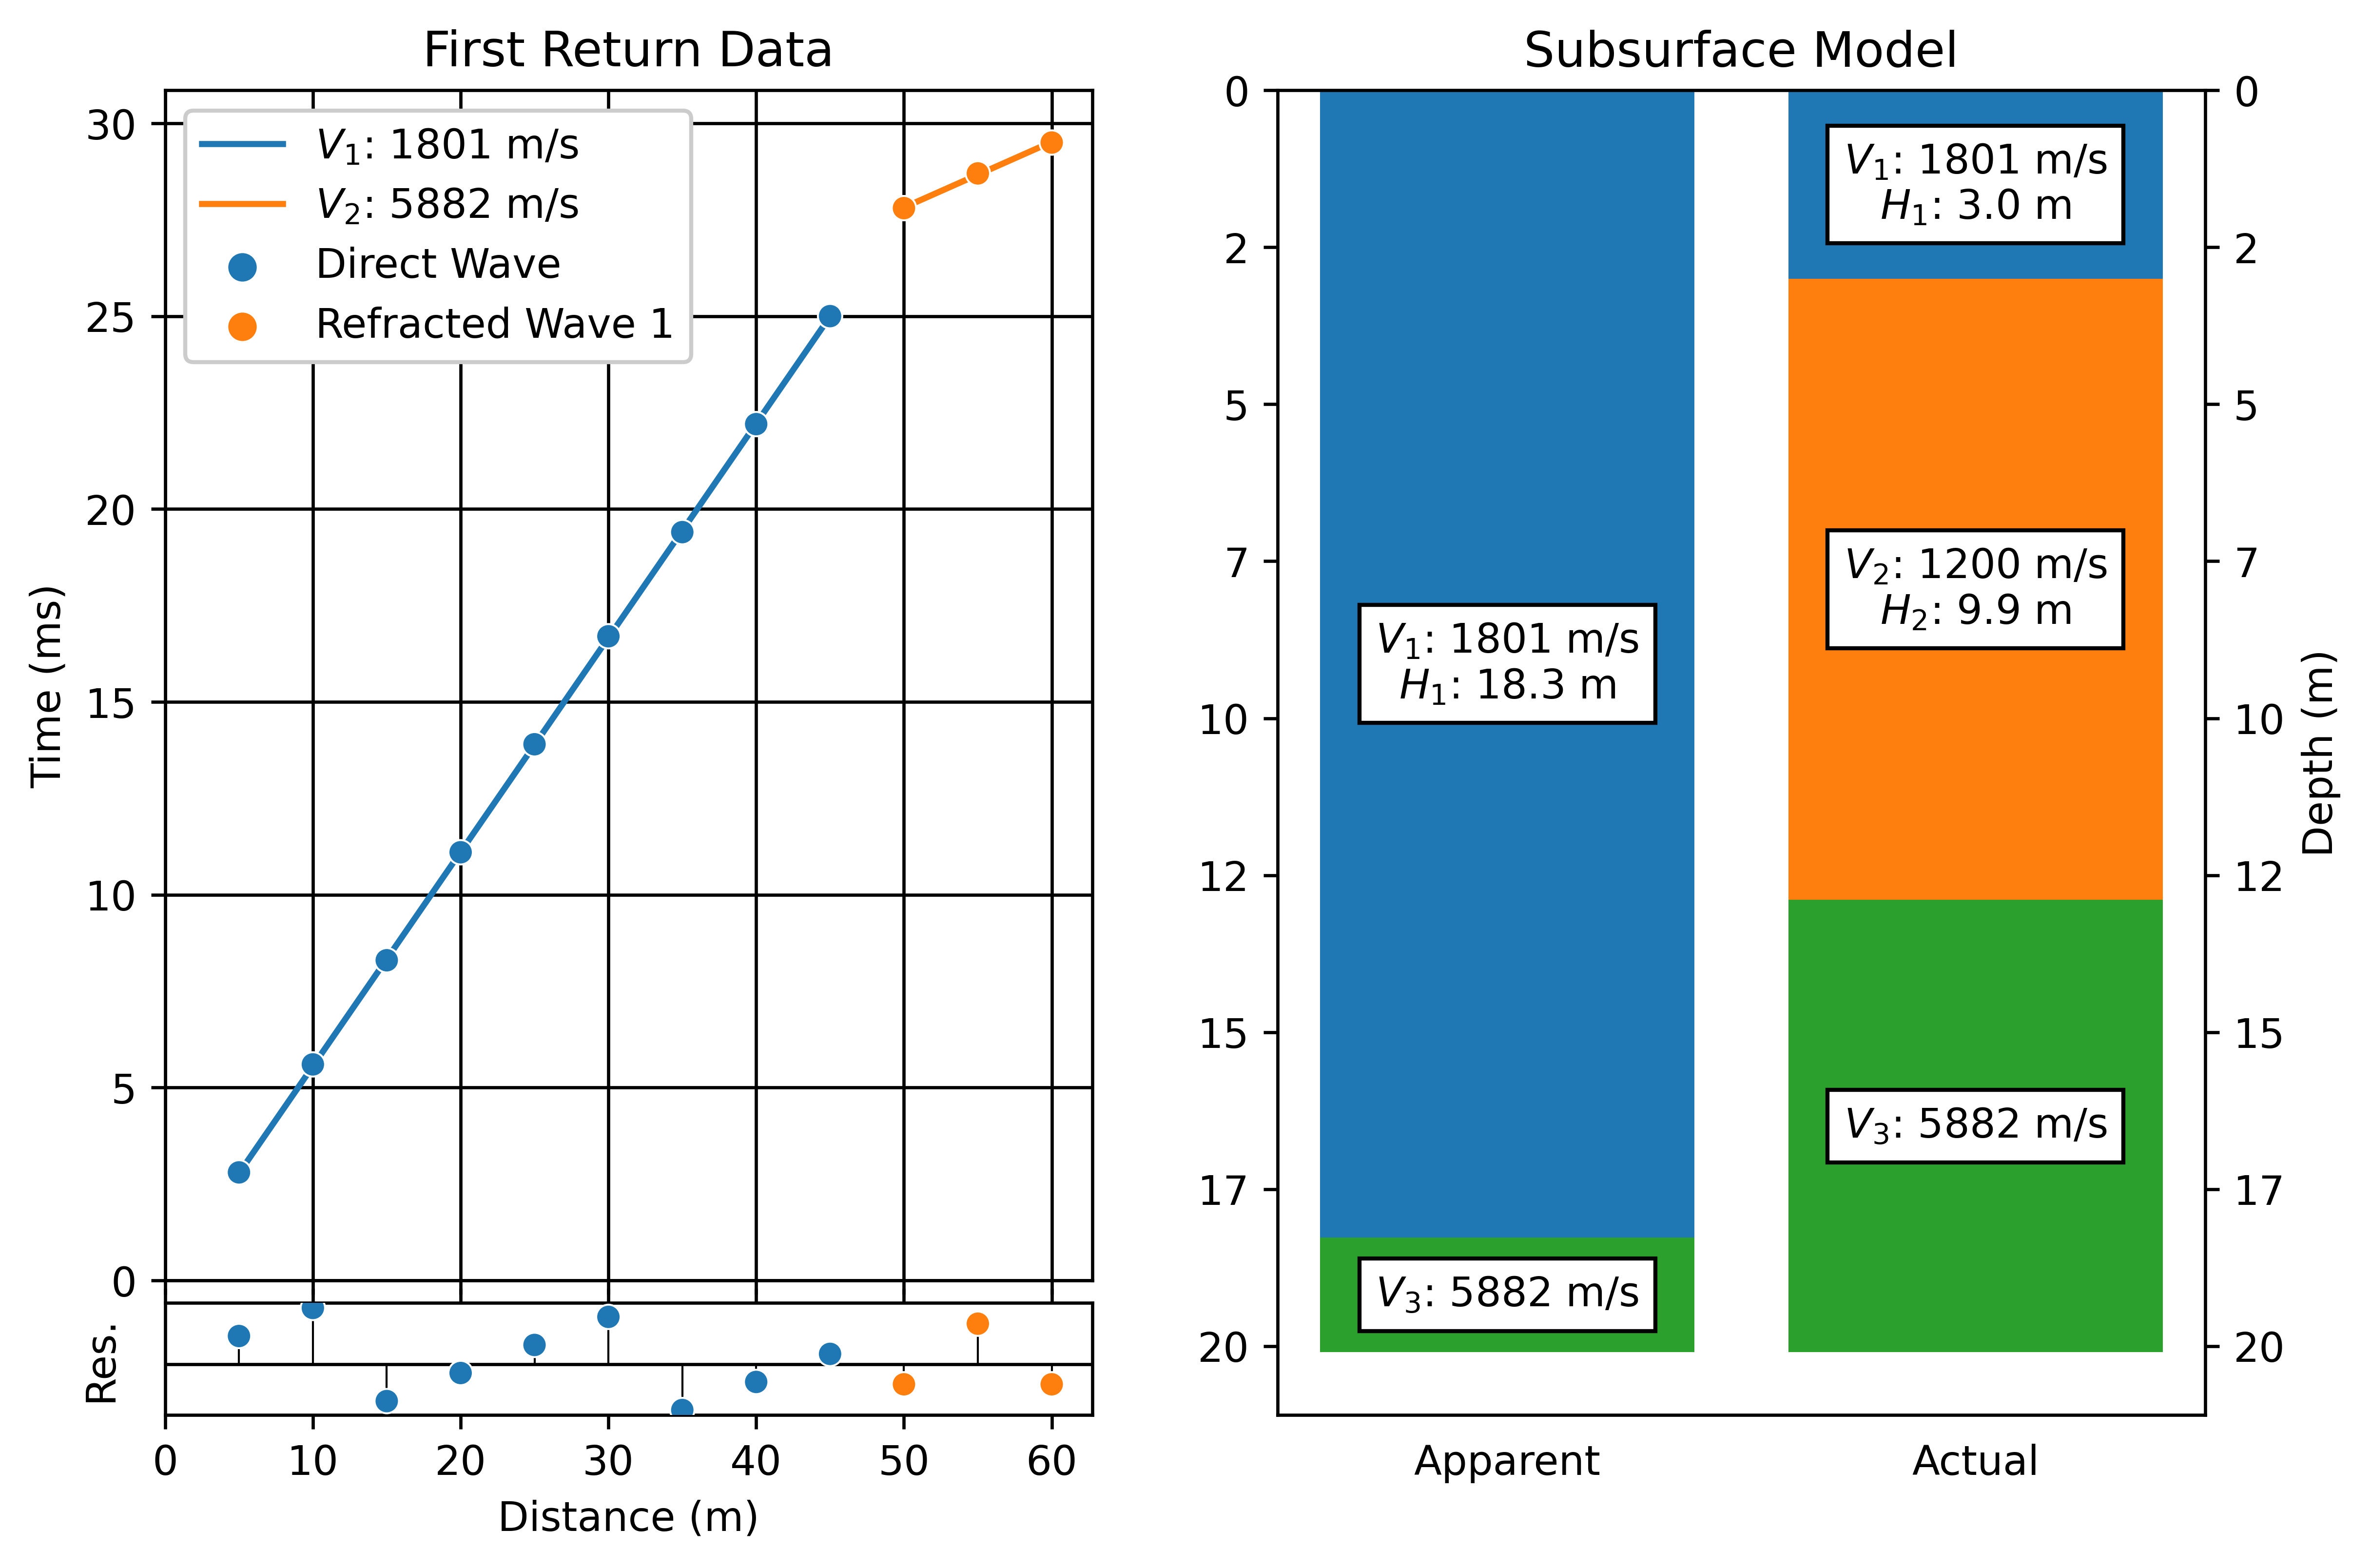

In [122]:
data_Q2 = np.array([
[5,     2.38 ],
[10,	4.76 ],
[15,	7.14 ],
[20,	9.52 ],
[25,	11.90],
[30,	13.37],
[35,	14.09],
[40,	14.80],
[45,	15.51],
[50,	16.23],
[55,	16.94],
[60,	17.66],
[65,	18.37],
[70,	19.09],
[75,	19.80],
[80,	20.51],
[85,	21.23],
[90,	21.94],
[95,	22.66],
[100,	23.37],
[105,	24.09],
[110,	24.80],
[115,	25.51],
[120,	26.23]])

# convert ms to s
data_Q2[:,1] = data_Q2[:,1] / 1000

trace_Q2 = RefractTrace(data_Q2)

trace_Q2.setup_model(breakpoints=[5])
trace_Q2.model()
trace_Q2.plot("2")

data_Q3 = np.array([
    [5, 2.8],
    [10, 5.6],
    [15, 8.3],
    [20, 11.1],
    [25, 13.9],
    [30, 16.7],
    [35, 19.4],
    [40, 22.2],
    [45, 25.0],
    [50, 27.8],
    [55, 28.7],
    [60, 29.5]
])

# convert ms to s 
data_Q3[:,1] = data_Q3[:,1] / 1000

trace_Q3 = RefractTrace(data_Q3)

trace_Q3.setup_model(breakpoints = [10])
trace_Q3.model()
trace_Q3.model_hidden_layer(above_layer_thickness=3, low_velocity=1200, num_layers_above=1)
trace_Q3.plot("3")

trace_Q3.setup_model(breakpoints = [9])
trace_Q3.model()
trace_Q3.model_hidden_layer(above_layer_thickness=3, low_velocity=1200, num_layers_above=1)
trace_Q3.plot("3-wrong")

<ipython-input-118-9f2144c275d3>:45: RuntimeWarning: divide by zero encountered in double_scalars
  return sqrt(vn ** 2 - vk ** 2) / (vn * vk)
<ipython-input-118-9f2144c275d3>:148: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([int(1000 * tick) for tick in time_ticks])
<ipython-input-118-9f2144c275d3>:242: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([int(abs(tick)) for tick in depth_ticks])


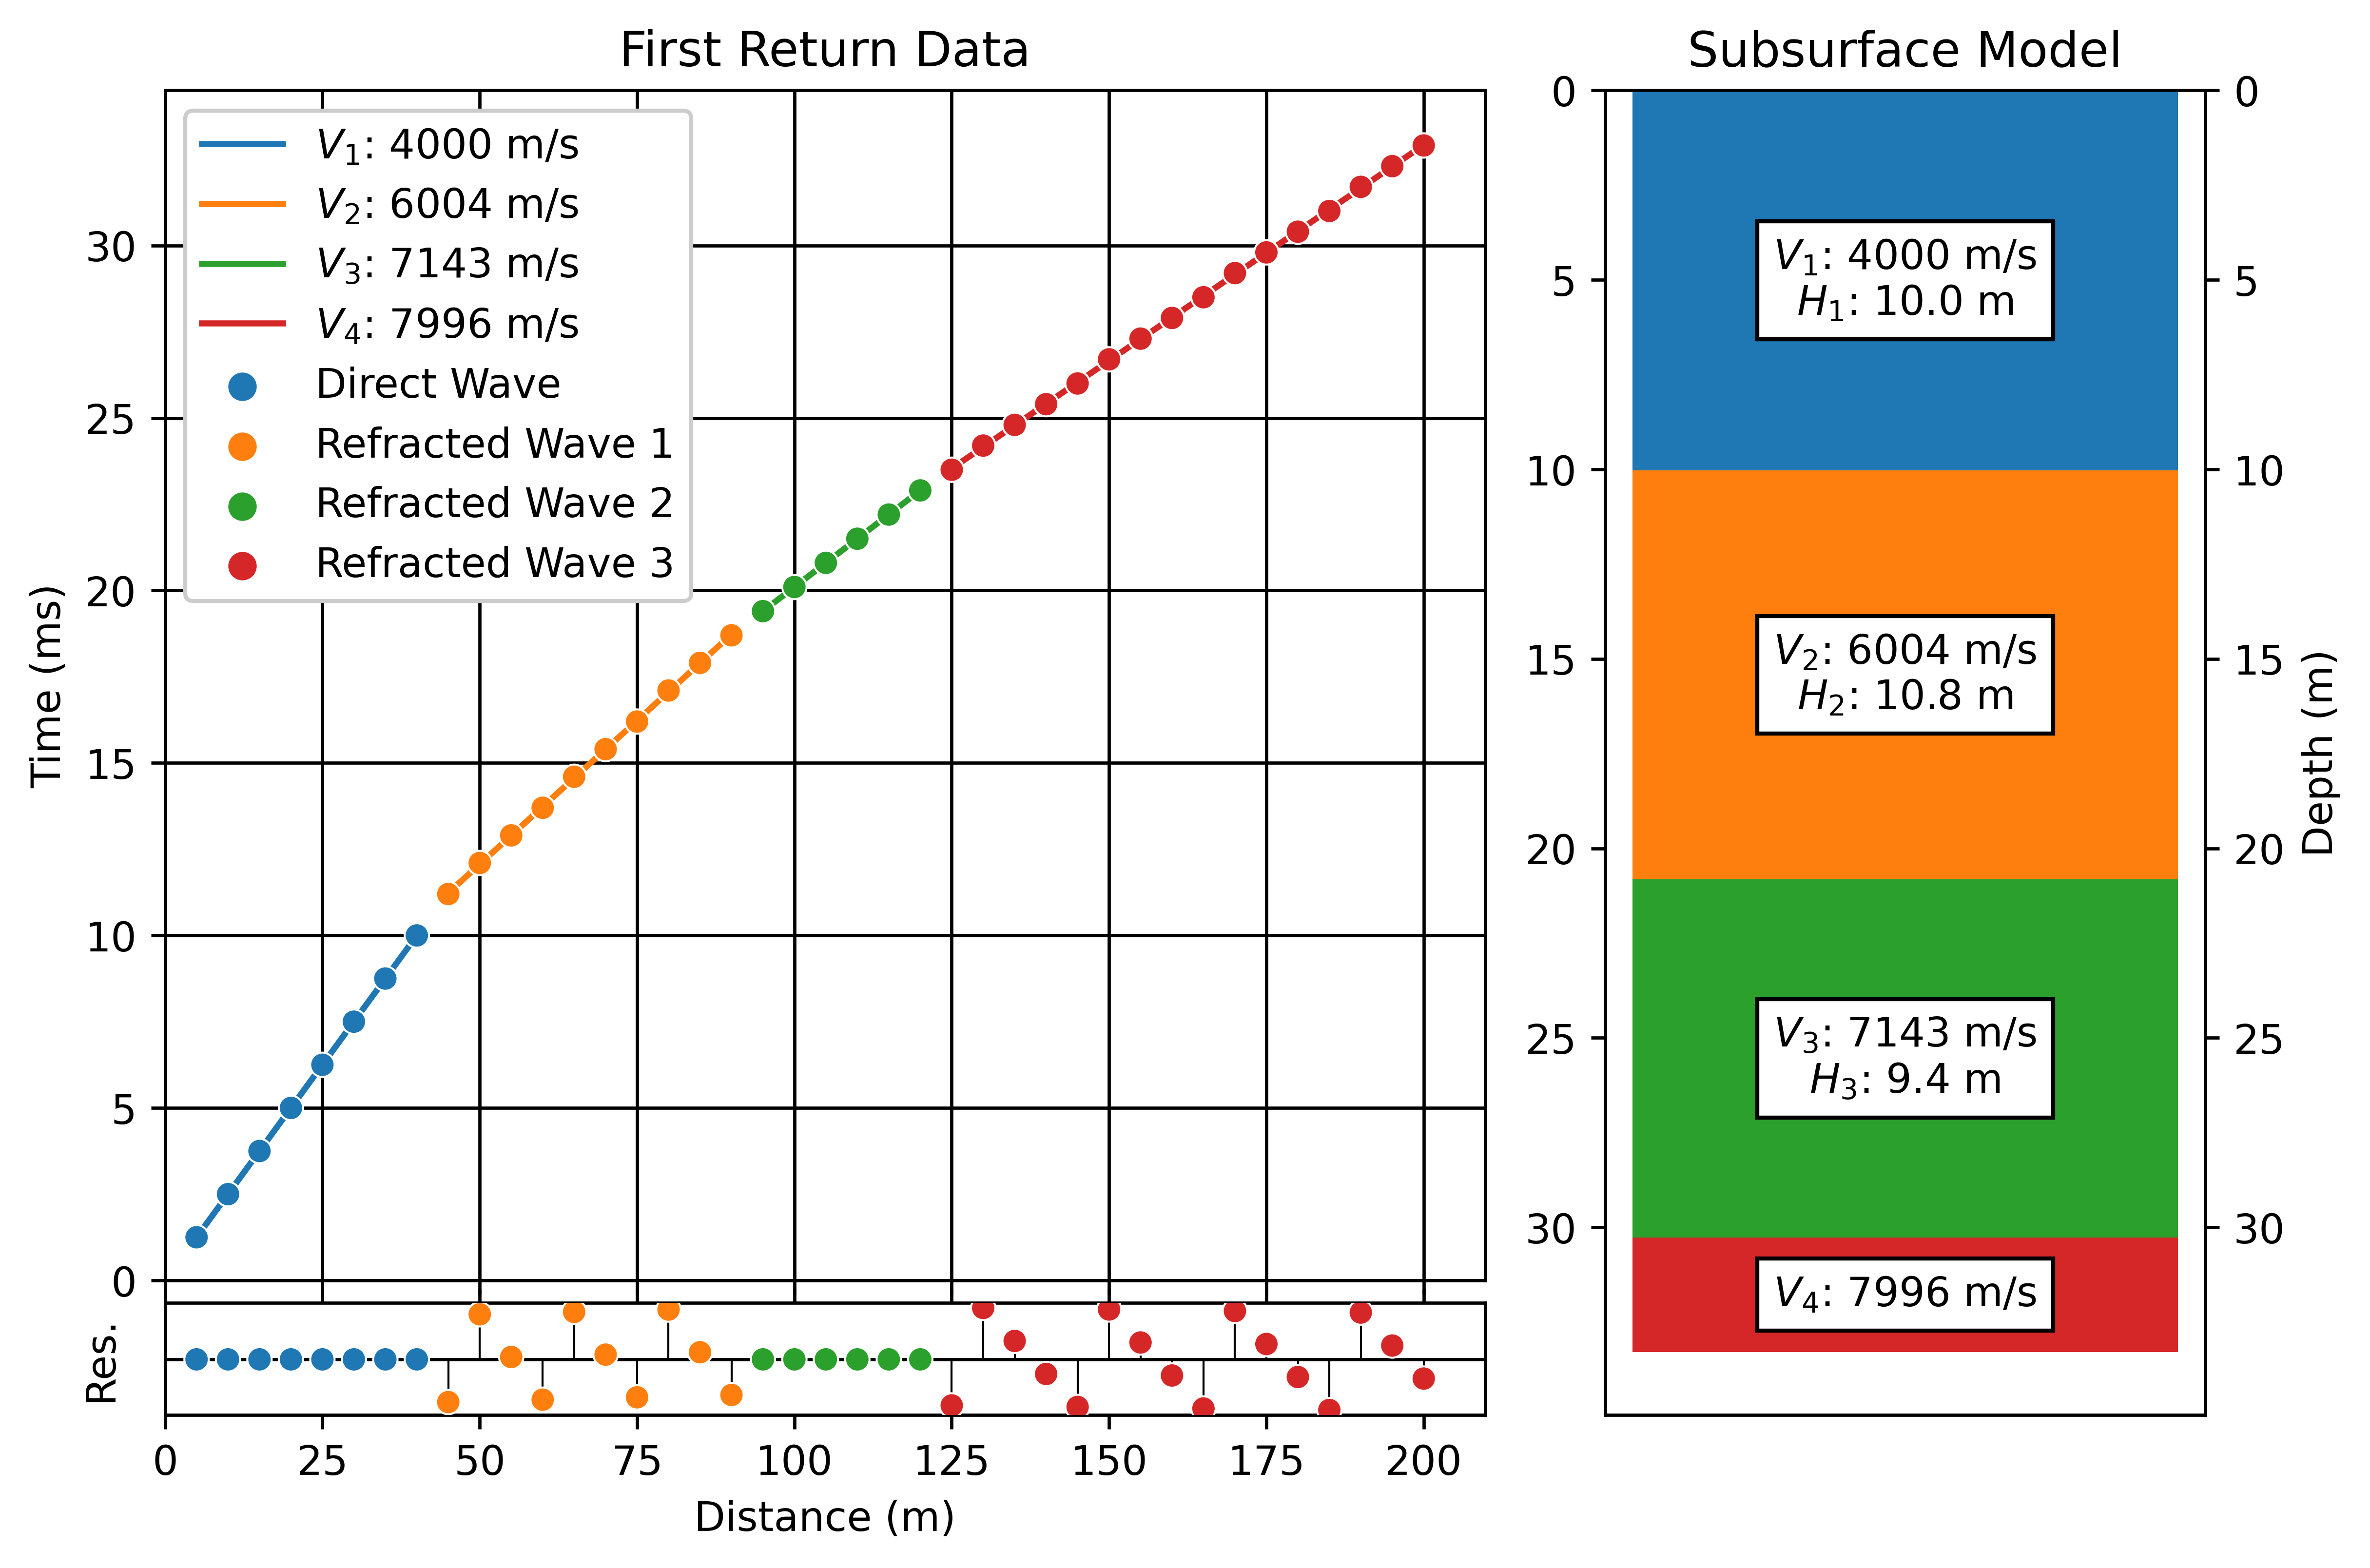

In [120]:
x = np.arange(5,205,5)
t = [1.25, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10, 11.2, 12.1, 12.9, 13.7, 14.6, 15.4, 16.2, 17.1, 17.9, 18.7, 19.4, 20.1, 20.8, 21.5, 22.2, 22.9, 23.5, 24.2, 24.8, 25.4, 26, 26.7, 27.3, 27.9, 28.5, 29.2, 29.8, 30.4, 31.0, 31.7, 32.3, 32.9]

data_test = np.array([[x[i], t[i]] for i in range(len(x))])

data_test[:,1] = data_test[:,1] / 1000

trace_test = RefractTrace(data_test)

trace_test.setup_model(breakpoints=[8, 18, 24])
trace_test.model()
trace_test.plot("test")


In [121]:
data_something = np.array([
    [  5. ,  10. ],
    [ 10. ,  20. ],
    [ 15. ,  30. ],
    [ 20. ,  40. ],
    [ 25. ,  49.2],
    [ 30. ,  51.2],
    [ 35. ,  53.2],
    [ 40. ,  55.2],
    [ 45. ,  57.2],
    [ 50. ,  59.2],
    [ 55. ,  61.2],
    [ 60. ,  63.2],
    [ 65. ,  65.2],
    [ 70. ,  67.2],
    [ 75. ,  69.2],
    [ 80. ,  71.2],
    [ 85. ,  73.2],
    [ 90. ,  74.7],
    [ 95. ,  75.9],
    [100. ,  77.2],
    [105. ,  78.4],
    [110. ,  79.7],
    [115. ,  80.9],
    [120. ,  82.2]
    ])

In [20]:
trace_TR.t - trace_TR.t_calculated

array([-2.30769231e-05,  1.53846154e-05,  0.00000000e+00, -1.38777878e-17,
        0.00000000e+00,  5.58333333e-05, -2.16666667e-05, -1.99166667e-04,
        4.23333333e-04,  4.58333333e-05, -3.31666667e-04,  2.90833333e-04,
       -8.66666667e-05, -4.64166667e-04,  1.58333333e-04, -2.19166667e-04,
        4.03333333e-04,  2.58333333e-05, -3.51666667e-04,  2.70833333e-04])

In [22]:
trace_TR.t_residual


array([-2.30769231e-05,  1.53846154e-05,  0.00000000e+00, -1.38777878e-17,
        0.00000000e+00,  5.58333333e-05, -2.16666667e-05, -1.99166667e-04,
        4.23333333e-04,  4.58333333e-05, -3.31666667e-04,  2.90833333e-04,
       -8.66666667e-05, -4.64166667e-04,  1.58333333e-04, -2.19166667e-04,
        4.03333333e-04,  2.58333333e-05, -3.51666667e-04,  2.70833333e-04])